# Mexican Flat Slab model

* Mor-Sz dist at 40 Ma, ~2000 km
* Mor-Sz dist at 0 Ma, ~600 km
* Mor average Vel ~ 4 cm/y
* UP vel ~ 2 cm/y
* Sp vel (35 - 10 Ma) ~ 8 cm/y
* Sp vel (10 - 0 Ma) ~ 3 cm/y

In [56]:
#!apt-cache policy petsc-dev

In [2]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator

import warnings; warnings.simplefilter('ignore')

In [3]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../../unsupported')
    sys.path.append('../../UWsubduction/Examples')
except:
    pass

In [4]:
#load in parent stuff
#%load_ext autoreload
#import nb_load_stuff
#from tectModelClass import *

from unsupported_dan.UWsubduction.model import *

In [5]:
from unsupported_dan.UWsubduction.subduction_utils import *
from unsupported_dan.interfaces.smoothing2D import *
from unsupported_dan.utilities.misc import cosine_taper
from unsupported_dan.interfaces.interface2D import interface2D , interface_collection

## Create output dir structure

In [6]:
#outputPath = os.path.join(os.path.abspath("."),"output/")
outputPath = os.path.join(os.path.abspath("."),"output/files")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

## Parameters / Scaling

* For more information see, `UWsubduction/Background/scaling`


In [7]:
from unsupported_dan.UWsubduction.minimal_example import UnitRegistry
u = UnitRegistry

In [8]:
#pd refers to dimensional paramters
pd = edict({})

#Main physical paramters (thermal convection parameters)
pd.refDensity = 3300.* u.kilogram / u.meter**3                    #reference density
pd.refGravity = 9.8* u.metre / u.second**2                        #surface gravity
pd.refDiffusivity = 1e-6 *u.metre**2 / u.second                   #thermal diffusivity
pd.refExpansivity = 3e-5/u.kelvin                                 #surface thermal expansivity
pd.refViscosity = 1e20* u.pascal* u.second
pd.refLength = 2900*u.km
pd.gasConstant = 8.314*u.joule/(u.mol*u.kelvin)                   #gas constant
pd.specificHeat = 1250.4*u.joule/(u.kilogram* u.kelvin)           #Specific heat (Jkg-1K-1)
pd.potentialTemp = 1573.*u.kelvin                                 #mantle potential temp (K)
pd.surfaceTemp = 273.*u.kelvin                                    #surface temp (K)
#these are the shifted temps, which will range from 0 - 1 in the dimensionless system
pd.potentialTemp_ = pd.potentialTemp - pd.surfaceTemp
pd.surfaceTemp_ = pd.surfaceTemp - pd.surfaceTemp
#main rheology parameters
pd.cohesionMantle = 20.*u.megapascal                              #mantle cohesion in Byerlee law
pd.frictionMantle = u.Quantity(0.2)                                           #mantle friction coefficient in Byerlee law (tan(phi))
pd.frictionMantleDepth = pd.frictionMantle*pd.refDensity*pd.refGravity
pd.diffusionPreExp = 5.34e-10/u.pascal/u.second                   #pre-exp factor for diffusion creep
pd.diffusionEnergy = 3e5*u.joule/(u.mol)
pd.diffusionEnergyDepth = 3e5*u.joule/(u.mol*pd.gasConstant)
pd.diffusionVolume=5e-6*u.meter**3/(u.mol)
pd.diffusionVolumeDepth=5e-6*pd.refDensity.magnitude*pd.refGravity.magnitude*u.joule/(u.mol*pd.gasConstant*u.meter)
pd.viscosityFault = 5e19*u.pascal   * u.second
pd.adiabaticTempGrad = (pd.refExpansivity*pd.refGravity*pd.potentialTemp)/pd.specificHeat
pd.yieldStressMax=200*u.megapascal
pd.lowerMantleViscFac = u.Quantity(30.0)

paramDict_dim = pd

In [9]:
md = edict({})
#Model geometry, and misc Lengths used to control behaviour
md.depth=1000*u.km                                                #Model Depth
md.aspectRatio=5.
#lengths, factors relating to subduction fault behaviour
md.faultViscDepthTaperStart = 100*u.km
md.faultViscDepthTaperWidth = 20*u.km
md.faultViscHorizTaperStart = 300*u.km
md.faultViscHorizTaperWidth = 300*u.km
md.faultThickness = 10.*u.km
md.faultLocFac = 1.                                                #this is the relative location of the fault in terms of the fault thickess from the top of slab
md.faultDestroyDepth = 300*u.km
md.lowerMantleDepth=660.*u.km
md.lowerMantleTransWidth=10.*u.km
#Slab and plate init. parameters
md.subZoneLoc=-100*u.km                                           #X position of subduction zone...km
md.slabInitMaxDepth=150*u.km
md.radiusOfCurv = 350.*u.km                                        #radius of curvature
md.slabAge=15.*u.megayears                                      #age of subduction plate at trench
md.opAgeAtTrench=10.*u.megayears                                        #age of op
#numerical and computation params
md.res=48
md.ppc=25                                                         #particles per cell
md.elementType="Q1/dQ0"
md.refineHoriz = True
md.refineVert = True
md.meshRefineFactor = 0.7
md.nltol = 0.01
md.druckerAlpha = 1.
md.penaltyMethod = True
md.buoyancyFac = 1.0
md.viscosityMin = 1e18* u.pascal * u.second
md.viscosityMax = 1e25* u.pascal * u.second

modelDict_dim = md

In [10]:
#import parameters, model settings, unit registry, scaling system, etc

from unsupported_dan.UWsubduction.default_scaling import sub_scaling, build_nondim_dict
from unsupported_dan.UWsubduction.minimal_example import rayleighNumber, stressScale, pressureDepthGrad


#define some more concise names
sca = sub_scaling
ndimlz = sca.nonDimensionalize
#build the dimensionless paramter / model dictionaries
ndp = build_nondim_dict(paramDict_dim  , sca)   
md = build_nondim_dict(modelDict_dim  , sca)
ur = u

assert ndimlz(paramDict_dim.refLength) == 1.0

# changes to base params: (These will keep changing if the notebook is run again without restarting!)
md.faultThickness *= 1.5 #15 km
md.res = 48

## Build / refine mesh, Stokes Variables

In [11]:
#(ndp.rightLim - ndp.leftLim)/ndp.depth
#md.res = 64

In [12]:
yres = int(md.res)
xres = int(md.res*6) 

halfWidth = 0.5*md.depth*md.aspectRatio 

minCoord_    = (-1.*halfWidth, 1. - md.depth) 
maxCoord_    = (halfWidth, 1.)

mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = minCoord_, 
                                 maxCoord    = maxCoord_) 

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 ) 
    

velocityField.data[:] = 0.
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

In [13]:
#mesh.reset() #call to reset mesh nodes to original locations

if md.refineHoriz:
    
    with mesh.deform_mesh():
        
        normXs = 2.*mesh.data[:,0]/(mesh.maxCoord[0] - mesh.minCoord[0])
        mesh.data[:,0] = mesh.data[:,0] * np.exp(md.meshRefineFactor*normXs**2) / np.exp(md.meshRefineFactor*1.0**2)    
    
if md.refineVert:

    with mesh.deform_mesh():
        
        mesh.data[:,1] = mesh.data[:,1] - 1.0

        normYs = -1.*mesh.data[:,1]/(mesh.maxCoord[1] - mesh.minCoord[1])
        mesh.data[:,1] = mesh.data[:,1] * np.exp(md.meshRefineFactor*normYs**2)/np.exp(md.meshRefineFactor*1.0**2)

        mesh.data[:,1] = mesh.data[:,1] + 1.0


## Build plate model

In [14]:

endTime = ndimlz(30*ur.megayear) 
refVel = ndimlz(2*ur.cm/ur.year)
plateModelDt = ndimlz(0.1*ur.megayear)

In [15]:
#velocities of the plates (1 - 3) ams well as the plate boundary (1,2)
vp1= ndimlz(0.*ur.centimeter/ur.year )
vp2= ndimlz(6.*ur.centimeter/ur.year )
vp3= ndimlz(-2.*ur.centimeter/ur.year )

vb12= ndimlz(4.0*ur.centimeter/ur.year )


In [16]:
print(vp1, vp2, vp3, vb12)

(0.0, 5513.845047502417, -1837.9483491674725, 3675.896698334945)


In [17]:
tm = TectModel(mesh, 0, endTime, plateModelDt)

tm.add_plate(1, velocities=vp1)
tm.add_plate(2, velocities=vp2)
tm.add_plate(3, velocities=vp3)

In [73]:
ridgeLoc = -0.7
subLoc = ridgeLoc  + ndimlz(2000.*ur.kilometer)
print(ridgeLoc, subLoc)

(-0.8, -0.1103448275862069)


In [74]:
tm.add_left_boundary(1, plateInitAge=md.slabAge/3., velocities=False)
#tm.add_left_boundary(2, plateInitAge=0., velocities=False)

tm.add_ridge(1,2, ridgeLoc, velocities=vb12)
tm.add_subzone(2, 3, subLoc, subInitAge=md.slabAge, upperInitAge=md.opAgeAtTrench)

tm.add_right_boundary(3, plateInitAge=0.0, velocities=False)

In [75]:
#((1400*ur.kilometer)/(35*ur.megayear)).to(ur.cm/ ur.year )


## Build plate age / temperature Fns

In [76]:
pIdFn = tm.plate_id_fn()
pAgeDict = tm.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tm.mesh, fnAge_map ))
#fig.show()

In [77]:
#ndp.potentialTemp

In [78]:
coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1]

platethickness = 2.32*fn.math.sqrt(1.*fnAge_map )  

halfSpaceTemp = ndp.potentialTemp_*fn.math.erf((depthFn)/(2.*fn.math.sqrt(1.*fnAge_map)))

plateTempProxFn = fn.branching.conditional( ((depthFn > platethickness, ndp.potentialTemp_ ), 
                                           (True,                      halfSpaceTemp)  ))



In [79]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tm.mesh, plateTempProxFn, onMesh = True))
#fig.show()

## Make swarm and Swarm Vars

In [80]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(md.ppc))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )

#
proxyTempVariable.data[:] = 1.0
proximityVariable.data[:] = 0.0
signedDistanceVariable.data[:] = 0.0


## Create tmUwMap

In [81]:
#Now we have built are primary FEM / Swarm objects, we collect some of these in a dictionary,
#to provide a consistent form to pass to methods of TectModel

tmUwMap = tm_uw_map([], velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)

## Make slab perturbation and subduction interface

* For more information see, `UWsubduction/Background/interface2D`

In [82]:
def circGradientFn(S):
    if S == 0.:
        return 0.
    elif S < md.radiusOfCurv:
        return max(-S/np.sqrt((md.radiusOfCurv**2 - S**2)), -1e3)
    else:
        return -1e5
    
    
def circGradientFn2(S):
    if S == 0.:
        return 0.
    elif S < 1.*md.radiusOfCurv:
        return max(-S/np.sqrt((md.radiusOfCurv**2 - S**2)), -1.)
    else:
        return -1.

def circGradientFn3(S):
    if S < 1.*md.radiusOfCurv:
        return circGradientFn2(S)
    else:
        return min(circGradientFn2(2.6*md.radiusOfCurv - S), -0.1)
    

In [83]:
#proxyTempVariable.data[:] =0.

In [84]:
#All of these wil be needed by the slab / fault setup functions
#We have two main options, bind them to the TectModel class. 
#or provide them to the functions
#collection them in a dictionary may be a useful way too proviede them to the function 
#without blowing out the function arguments

tmUwMap = tm_uw_map([], velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)


In [85]:
#define fault particle spacing, here ~5 paricles per element
ds = (tm.maxX - tm.minX)/(2.*tm.mesh.elementRes[0])

fCollection = interface_collection([])

deepDepth = ndimlz(300.*ur.kilometer)

for e in tm.undirected.edges():
    if tm.is_subduction_boundary(e):
        build_slab_distance(tm, e, circGradientFn3, deepDepth, tmUwMap)
        #build_slab_distance(tm, e, circGradientFn, md.slabInitMaxDepth, tmUwMap)        
        fb = build_fault(tm, e, circGradientFn3, md.faultThickness , deepDepth, ds, md.faultThickness, tmUwMap)
        #fb = build_fault(tm, e, circGradientFn, md.faultThickness , md.slabInitMaxDepth, ds, md.faultThickness, tmUwMap)

        fCollection.append(fb)

#
build_slab_temp(tmUwMap, ndp.potentialTemp_, md.slabAge)
fnJointTemp = fn.misc.min(proxyTempVariable,plateTempProxFn)

#And now reevaluate this guy on the swarm
proxyTempVariable.data[:] = fnJointTemp.evaluate(swarm)


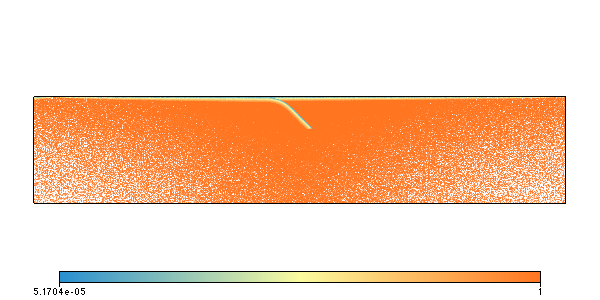

In [87]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Points(swarm, proxyTempVariable))
#fig.append( glucifer.objects.Points(fb.swarm))
#fig.show()
#fig.save_database('test.gldb')

##  Define subduction fault evolution (rebuild/destroy)


In this section we setup some functions to help manage the spatial distribution of faults

In [34]:
# Setup a swarm to define the replacment positions

fThick= fCollection[0].thickness

faultloc = 1. - md.faultThickness*md.faultLocFac

allxs = np.arange(mesh.minCoord[0], mesh.maxCoord[0], ds )[:-1]
allys = (mesh.maxCoord[1] - fThick)*np.ones(allxs.shape)

faultMasterSwarm = uw.swarm.Swarm( mesh=mesh )
dummy =  faultMasterSwarm.add_particles_with_coordinates(np.column_stack((allxs, allys)))
del allxs
del allys



##What are we doing here??

#*faultRmfn descibs an area around the trench in which fault particles are allowed. Outside of this region they
#are destroyed using (remove_faults_from_boundaries). Note that the

#* faultAddFn desribes a region internal to the subduction plate wherwe we rebuild the fault. 
#this function deliberately'over-builds' the fault, while remove_faults_from_boundaries then trims it to size

#* velMaskFn defines the nodes where we will apply the plate velocties. 
#While leaving nodes near the plate boundaries free to adjust


faultRmfn = tm.t2f(tm.variable_boundary_mask_fn(distMax=1e5, distMin=ndimlz(10*ur.km), relativeWidth = 0.9, 
                                  minPlateLength =ndimlz(60*ur.km),  
                                           out = 'bool', boundtypes='sub' ))


#this one will put particles back into the fault
faultAddFn1 = tm.variable_boundary_mask_fn(distMax=1e6, distMin=ndimlz(10*ur.km), 
                                       relativeWidth = 0.95, minPlateLength =ndimlz(60*ur.km),  
                                           out = 'bool', boundtypes='sub' )

#thsi will keep the fault addition away from the subdcution zone
faultAddFn2 =  tm.t2f(tm.variable_boundary_mask_fn(distMax = ndimlz(150*ur.km), relativeWidth = 0.9 ))

faultAddFn = operator.and_( faultAddFn1 ,  faultAddFn2)




###The following mask function provide a way of building velocity conditions within the plates,

velMask1 = tm.variable_boundary_mask_fn(distMax=1e6, distMin=0.0, relativeWidth = 0.85, 
                        minPlateLength =ndimlz(50*ur.km),  out = 'bool', boundtypes='ridge')

velMask2= tm.plate_interior_mask_fn(relativeWidth=0.95, 
                                        minPlateLength=ndimlz(10*ur.km), invert=False)

velMaskFn = operator.and_( velMask1,  velMask2)


#order is very important here
#dummy = remove_fault_drift(fCollection, faultloc)
#dummy = pop_or_perish(tm, fCollection, faultMasterSwarm, faultAddFn , ds)
#dummy = remove_faults_from_boundaries(tm, fCollection, faultRmfn )


In [35]:
#maskFn_ = tm.t2f(faultRmfn)
#pIdFn = tm.plate_id_fn(maskFn=maskFn_)

In [36]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tm.mesh, pIdFn, onMesh=True, valueRange = [0,3]))
#fig.show()

## Proximity



In [37]:
proximityVariable.data[:] = 0

In [38]:
for f in fCollection:
    f.rebuild()
    f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0)

In [39]:
#update_faults()

In [40]:
#figProx = glucifer.Figure(figsize=(960,300) )
#figProx.append( glucifer.objects.Points(swarm , proximityVariable))
#figProx.append( glucifer.objects.Surface(mesh, velMaskFn))

#for f in fCollection:
#    figProx.append( glucifer.objects.Points(f.swarm, pointSize=5))
#figProx.show()


#figProx.save_database('test.gldb')

In [41]:
#testMM = fn.view.min_max(uw.function.input(f.swarm.particleCoordinates))
#dummyFn = testMM.evaluate(tWalls)

## Prescribed velocity

In [42]:
def set_vel_return_nodes(time, maskFn):
    """
    globals:
    velocityField
    """
    
    nodes = tm.plate_vel_node_fn(time, maskFn = maskFn)
    
    #4 parallel safety
    if not nodes.shape[0]:
        return np.array([])
        
    pIdFn = tm.plate_id_fn()
    #velMapFn = tm.plateVelFn(testTime, pIdFn)
    velMapFn = tm.plateVelFn(time, pIdFn)
    locs = tm.mesh.data[nodes]

    #Now set the veolcity on the nodes
    velocityField.data[nodes, 0] = velMapFn.evaluate(locs)[:,0]
    return nodes
    

In [43]:
vXnodes = set_vel_return_nodes(0., velMaskFn)

In [44]:
#np.empty(0), 
#test = tm.mesh.specialSets['MaxJ_VertexSet']data.shape

In [45]:
#check
#%pylab inline
#tWalls = tm.mesh.specialSets['MaxJ_VertexSet']


#fig, ax = plt.subplots(figsize=(10, 2))
#plt.plot(mesh.data[tWalls.data][:,0], velocityField.data[tWalls.data][:,0])#
#plt.scatter(mesh.data[vXnodes ][:,0], np.zeros(len(mesh.data[vXnodes ][:,0])), s = 0.5, c = 'k')
#ax.hlines(500, tm.minX, tm.maxX, linestyles='--')

## Project the swarm 'proxy temp' to mesh

In [46]:
projectorMeshTemp= uw.utils.MeshVariable_Projection( temperatureField, proxyTempVariable , type=0 )
projectorMeshTemp.solve()

## Boundary conditions

In [47]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls = mesh.specialSets["MinJ_VertexSet"]


#velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
#                                           indexSetsPerDof = (iWalls, jWalls) )


In [48]:
#vXnodes

In [49]:
def build_velBcs(nodes):
    
    velnodeset = mesh.specialSets["Empty"]
    velnodeset += nodes
    
    
    
    velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls + velnodeset, jWalls) )
    
    return velBC

In [50]:
velBC = build_velBcs(vXnodes)

In [52]:
#Ridges enforced
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls + iWalls,) )


###If we want thermal ridges fixed
temperatureField.data[iWalls.data] = ndp.potentialTemp_

## Bouyancy

In [53]:
temperatureFn = temperatureField


# Now create a buoyancy force vector using the density and the vertical unit vector. 
thermalDensityFn = md.buoyancyFac*rayleighNumber*(1. - temperatureFn)

gravity = ( 0.0, -1.0 )

buoyancyMapFn = thermalDensityFn*gravity

## Rheology

In [54]:
symStrainrate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )

#Set up any functions required by the rheology
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))



def safe_visc(func, viscmin=md.viscosityMin, viscmax=md.viscosityMax):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [55]:
#Interface rheology extent

subZoneDistfn = tm.subZoneAbsDistFn(upper=True)


faultHorizTaperFn  = cosine_taper(subZoneDistfn, 
                                  md.faultViscHorizTaperStart, md.faultViscHorizTaperWidth)
faultDepthTaperFn = cosine_taper(depthFn, 
                                 md.faultViscDepthTaperStart, md.faultViscDepthTaperWidth)

In [56]:
#temperatureField, 

ndp.diffusionPreExp, ndp.diffusionVolumeDepth, ndp.diffusionEnergyDepth, ndp.surfaceTemp
#(1./ndp.diffusionPreExp)


(53400000000.0, 43.386502840435966, 27.75670324383339, 0.21)

In [57]:


adiabaticCorrectFn = depthFn*ndp.adiabaticTempGrad
dynamicPressureProxyDepthFn = pressureField/pressureDepthGrad
druckerDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlpha*(dynamicPressureProxyDepthFn))

#Diffusion Creep
diffusionUM = (1./ndp.diffusionPreExp)*\
    fn.math.exp( ((ndp.diffusionEnergyDepth + \
                   (depthFn*ndp.diffusionVolumeDepth))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

diffusionUM =     safe_visc(diffusionUM)
    
diffusionLM = ndp.lowerMantleViscFac*(1./ndp.diffusionPreExp)*\
    fn.math.exp( ((ndp.diffusionEnergyDepth + \
                   (depthFn*ndp.diffusionVolumeDepth))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

#diffusionLM =     safe_visc(diffusionLM)


transitionZoneTaperFn = cosine_taper(depthFn, md.lowerMantleDepth - 0.5*md.lowerMantleTransWidth , md.lowerMantleTransWidth )


mantleCreep = diffusionUM*(1. - transitionZoneTaperFn) + transitionZoneTaperFn*diffusionLM

#Define the mantle Plasticity
ys =  ndp.cohesionMantle + (druckerDepthFn*ndp.frictionMantleDepth)
ysf = fn.misc.min(ys, ndp.yieldStressMax)
yielding = ysf/(2.*(strainRate_2ndInvariant) + 1e-15) 

mantleRheologyFn =  safe_visc(mantleCreep*yielding/(mantleCreep + yielding), 
                              viscmin=md.viscosityMin, viscmax=md.viscosityMax)


faultViscosityFn = ndp.viscosityFault

faultRheologyFn =  faultViscosityFn*(1. - faultDepthTaperFn) +  \
                       faultDepthTaperFn*mantleRheologyFn + faultHorizTaperFn*mantleRheologyFn


In [58]:
#viscconds = ((proximityVariable == 0, mantleRheologyFn),
#             (True, interfaceViscosityFn ))

#viscosityMapFn = fn.branching.conditional(viscconds)
#viscosityMapFn = mantleRheologyFn


viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                             mapping = {0:mantleRheologyFn,
                                        2:faultRheologyFn} )

In [59]:
#fig2 = glucifer.Figure(figsize=(960,300) )
#fig2.append( glucifer.objects.Points(swarm, mantleRheologyFn,  logScale=True))
#fig.append( glucifer.objects.Surface(mesh, dynamicPressureProxyDepthFn))

#fig2.show()

## Stokes

In [60]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)

NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressureField, type=0)
Nodes2Cell = uw.utils.MeshVariable_Projection(pressureField, NodePressure, type=0)

def smooth_pressure(mesh):
    # Smooths the pressure field.
    # Assuming that pressure lies on the submesh, do a cell -> nodes -> cell
    # projection.

    Cell2Nodes.solve()
    Nodes2Cell.solve()

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset
    smooth_pressure(mesh)

In [65]:
stokes = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velBC,],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = buoyancyMapFn )


In [66]:
solver = uw.systems.Solver(stokes)

solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4


In [67]:
solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol, callback_post_solve = pressure_calibrate)
solver.print_stats()


 
Pressure iterations:   6
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 2.7212e-01
Pressure solve time: 5.1414e-02
Velocity solve time: 2.8294e-01 (backsolve)
Total solve time   : 6.6662e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



In [68]:
## Advection - Diffusion

In [69]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureFn, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = ndp.refDiffusivity, 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )

## Swarm Advector

In [70]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )


In [71]:
population_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.006, 
                                                splitThreshold=0.25,maxDeletions=1, maxSplits=3, aggressive=True,
                                                aggressiveThreshold=0.9, particlesPerCell=int(md.ppc))

## Update functions

In [72]:
valuesDict = edict({})
valuesDict.timeAtSave = []
valuesDict.stepAtSave = []
for e in tm.undirected.edges():
    valuesDict[str(e)] = []
valuesDict  

{'(1, 1)': [],
 '(1, 2)': [],
 '(2, 3)': [],
 '(3, 3)': [],
 'stepAtSave': [],
 'timeAtSave': []}

In [73]:
# Here we'll handle everything that should be advected - i.e. every timestep
def advect_update(dt):
    # Retrieve the maximum possible timestep for the advection system.
    #dt = advector.get_max_dt()
    # Advect swarm
    advector.integrate(dt)
    
    #Advect faults
    for f in fCollection:
        f.advection(dt)
    
    
    return time+dt, step+1

In [74]:
def update_stokes(time, viscosityMapFn ):
    


    
    #set velocity / pressure back to zero
    #velocityField.data[:] = 0.
    #pressureField.data[:] = 0.
    
    #set the new surface vel, get the velXNodes
    vXnodes = set_vel_return_nodes(time, velMaskFn)
    
    #creat a BC object
    velBC = build_velBcs(vXnodes)
    
    
    
    #rebuild stokes
    stokes = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velBC,],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = buoyancyMapFn )
    return stokes

In [75]:
def rebuild_solver(stokes):
    
    solver = uw.systems.Solver(stokes)
    solver.set_inner_method("mumps")
    solver.options.scr.ksp_type="cg"
    solver.set_penalty(1.0e7)
    solver.options.scr.ksp_rtol = 1.0e-4
    
    return solver


In [76]:
def update_faults():
    
    
    #order is very important here
    dummy = remove_fault_drift(fCollection, faultloc)
    dummy = pop_or_perish(tm, fCollection, faultMasterSwarm, faultAddFn , ds)
    dummy = remove_faults_from_boundaries(tm, fCollection, faultRmfn )
    
    
    for f in fCollection:
        
        #Remove particles below a specified depth
        depthMask = f.swarm.particleCoordinates.data[:,1] <         (1. - md.faultDestroyDepth)
        with f.swarm.deform_swarm():
            f.swarm.particleCoordinates.data[depthMask] = (9999999., 9999999.)
        
        #The repair_interface2D routine is supposed to maintain particle density and smooth
        repair_interface2D(f, ds, k=8)
    


In [77]:
def update_swarm():
    
    population_control.repopulate()
    
    for f in fCollection:
        f.rebuild()
        f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0,
                                maxDistanceFn=fn.misc.constant(2.))
        
    #A simple depth cutoff for proximity
    depthMask = swarm.particleCoordinates.data[:,1] < (1. - md.faultDestroyDepth)
    proximityVariable.data[depthMask] = 0
    

In [78]:
outputPath = os.path.join(os.path.abspath("."),"output/files")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()


surfacexs = mesh.data[tWalls.data][:,0]
surfaceys = mesh.data[tWalls.data][:,1]
surfLine = interface2D(mesh, velocityField,surfacexs, surfaceys , 0,  99)
surfVx = uw.swarm.SwarmVariable(surfLine.swarm, 'double', 1)

def save_files(step):
    surfVx.data[:] = velocityField[0].evaluate(surfLine.swarm)
    
    surfVx.save( "output/files/surfVx_" + str(step).zfill(3) + "_.h5")

In [79]:
def update_tect_model(tectModel, tmUwMap, time, dt = 0.0 ):
    
    """
    An example of how we can update the tect_model
    """
    for e in tectModel.undirected.edges():
        
        #This is generally the first condition to check" a specified boundary velocity
        if tectModel.bound_has_vel(e, time):
            newX = get_boundary_vel_update(tectModel, e, time, dt)
            tectModel.set_bound_loc(e, newX)
            
        #in this model the ficticious boundaries remain fixed at the edge
        elif e[0] == e[1]:
            pass       
        #now we'll apply a strain rate query to update the subduction zone loc
        elif tectModel.is_subduction_boundary(e):
            e = tectModel.subduction_edge_order(e)
            newx = strain_rate_field_update(tectModel, e, tmUwMap, dist = ndimlz(100*ur.kilometer))
            tectModel.set_bound_loc(e, newx)
        else:
            pass


In [80]:
#update_tect_model(tm, tmUwMap, 0., dt = 0.1 )

In [81]:
def update_mask_fns():

    faultRmfn = tm.t2f(tm.variable_boundary_mask_fn(distMax=1e5, distMin=ndimlz(10*ur.km), relativeWidth = 0.9, 
                                      minPlateLength =ndimlz(60*ur.km),  
                                               out = 'bool', boundtypes='sub' ))

    #this one will put particles back into the fault
    faultAddFn1 = tm.variable_boundary_mask_fn(distMax=1e6, distMin=ndimlz(10*ur.km), 
                                           relativeWidth = 0.95, minPlateLength =ndimlz(60*ur.km),  
                                               out = 'bool', boundtypes='sub' )

    #thsi will keep the fault addition away from the subdcution zone
    faultAddFn2 =  tm.t2f(tm.variable_boundary_mask_fn(distMax = ndimlz(150*ur.km), relativeWidth = 0.9 ))

    faultAddFn = operator.and_( faultAddFn1 ,  faultAddFn2)




    ###The following mask function provide a way of building velocity conditions within the plates,

    velMask1 = tm.variable_boundary_mask_fn(distMax=1e6, distMin=0.0, relativeWidth = 0.85, 
                            minPlateLength =ndimlz(50*ur.km),  out = 'bool', boundtypes='ridge')

    velMask2= tm.plate_interior_mask_fn(relativeWidth=0.95, 
                                            minPlateLength=ndimlz(10*ur.km), invert=False)

    velMaskFn = operator.and_( velMask1,  velMask2)

    
    
    #the following dictates where the fault rheology will be activated
    subZoneDistfn = tm.subZoneAbsDistFn(upper=True)
    
    faultHorizTaperFn  = cosine_taper(subZoneDistfn, 
                                  md.faultViscHorizTaperStart, md.faultViscHorizTaperWidth)
    
    return faultRmfn, faultAddFn, velMaskFn, faultHorizTaperFn

In [82]:
#ridgeMaskFn, boundMaskFn, velMaskFn = update_mask_fns()

## Track the values of the plate bounaries

In [83]:
def update_values():
    
    """ 
    Assumes global variables:
    * time
    * step 
    ...
    + many functions
    """
    
    
    #save the time and step
    valuesDict.timeAtSave.append(time) 
    valuesDict.stepAtSave.append(step)
    
    for e in tm.undirected.edges():
        if tm.is_subduction_boundary(e):
            ee = tm.subduction_edge_order(e) #hacky workaround for the directed/ undireted. need get_bound_loc
        else:
            ee = e

        valuesDict[str(e)].append(tm.get_bound_loc(ee))
        
        
    #save
    if uw.rank()==0:
        fullpath = os.path.join(outputPath + "tect_model_data")
        #the '**' is important
        np.savez(fullpath, **valuesDict)
    

In [84]:
#valuesDict  
#!ls output

## Viz

In [85]:
outputPath = os.path.join(os.path.abspath("."),"output/")


if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

In [78]:
viscSwarmVar =  swarm.add_variable( dataType="double", count=1 )
viscSwarmVar.data[:] = viscosityMapFn.evaluate(swarm)

In [79]:
store1 = glucifer.Store('output/subduction1')
store2 = glucifer.Store('output/subduction2')
store3 = glucifer.Store('output/subduction3')


figTemp = glucifer.Figure(store1, figsize=(960,300) )
figTemp.append( glucifer.objects.Surface(mesh, temperatureField, onMesh=True))
figTemp.append( glucifer.objects.Contours(mesh, temperatureField, interval=0.2,  colours='Black', colourBar=False))          

figVisc = glucifer.Figure( store2, figsize=(960,300) )
#figVisc.append( glucifer.objects.Points(swarm, viscosityMapFn, pointSize=2, logScale=True) )
figVisc.append( glucifer.objects.Points(swarm,  viscSwarmVar, logScale=True) )



figVel = glucifer.Figure( store3, figsize=(960,300) )
figVel.append(glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField), onMesh=True))
figVel.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=1./refVel) )




#figMask.append( glucifer.objects.Surface(mesh,  maskFnVar3) )
for f in fCollection:
    figVel.append( glucifer.objects.Points(f.swarm, pointSize=5))



In [81]:
#figVisc.show()
#figVisc.save_database('test.gldb')

In [44]:
#1e-2*2900.

## Main Loop

In [132]:
time = 0.  # Initial time
step = 0 
maxSteps = 2000      # Maximum timesteps 
steps_output = 10   # output every N timesteps
swarm_update = 10   # output every N timesteps
faults_update = 10
dt_model = 0.
steps_update_model = 5

update_values()

In [47]:
while time < tm.times[-1] and step < maxSteps:
    
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol, callback_post_solve = pressure_calibrate)
    
    dt = advDiff.get_max_dt()
    advDiff.integrate(dt)
    
    #advect swarm and faults
    time, step =  advect_update(dt)
    dt_model += dt
    
        
    #update tectonic model
    if step % steps_update_model == 0:
        update_tect_model(tm, tmUwMap, time, dt = dt_model)
        dt_model = 0.
        plate_id_fn = tm.plate_id_fn()
        faultRmfn, faultAddFn, velMaskFn, faultHorizTaperFn = update_mask_fns()
        
        #these need to be explicity updated
        faultRheologyFn =  faultViscosityFn*(1. - faultDepthTaperFn) +\
        faultDepthTaperFn*mantleRheologyFn + faultHorizTaperFn*mantleRheologyFn
        
        viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                             mapping = {0:mantleRheologyFn,
                                        2:faultRheologyFn} )
        
        
        
    #running fault healing/addition, map back to swarm
    if step % faults_update == 0:
        update_faults()
    if step % swarm_update == 0:
        update_swarm()
        
    #rebuild stokes
    if step % steps_update_model == 0:
        del solver
        del stokes
        stokes = update_stokes(time, viscosityMapFn )
        solver = rebuild_solver(stokes)
        
    
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        
        update_values()
        
        #Important to set the timestep for the store object here or will overwrite previous step
        
        #also update this guy for viz
        viscSwarmVar.data[:] = viscosityMapFn.evaluate(swarm)
        
        store1.step = step
        store2.step = step
        store3.step = step
        figTemp.save(    outputPath + "temp"    + str(step).zfill(4))
        figVisc.save(    outputPath + "visc"    + str(step).zfill(4))
        figVel.save(    outputPath + "vel"    + str(step).zfill(4))
        
        #save out the surface velocity
        #save_files(step)
    
    if uw.rank()==0:
        print 'step = {0:6d}; time = {1:.3e}'.format(step,time)


step =      1; time = 8.138e-06
step =      2; time = 1.593e-05
step =      3; time = 2.334e-05
step =      4; time = 3.055e-05
step =      5; time = 3.749e-05
step =      6; time = 4.409e-05
step =      7; time = 5.039e-05
step =      8; time = 5.649e-05
step =      9; time = 6.228e-05
step =     10; time = 6.781e-05
step =     11; time = 7.324e-05
step =     12; time = 7.850e-05
step =     13; time = 8.339e-05
step =     14; time = 8.796e-05
step =     15; time = 9.223e-05
step =     16; time = 9.622e-05
step =     17; time = 1.000e-04
step =     18; time = 1.036e-04
step =     19; time = 1.070e-04
step =     20; time = 1.103e-04


In [88]:
#tm.is_ridge((3,3))

True